In [54]:
import pandas as pd
from flwr_datasets import FederatedDataset
from flwr_datasets.partitioner import IidPartitioner, DirichletPartitioner, PathologicalPartitioner
from datasets import Dataset
from modules.visualization_functions import showDataDist
from flwr_datasets.visualization import plot_label_distributions
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import OneHotEncoder
# import pandas as pd
import numpy as np
import flwr as fl
from sklearn.metrics import accuracy_score, log_loss

In [ ]:

def show_num_samples_per_client(partitions, number_of_clients):
    for client_id in range(number_of_clients):
        print(f"Client {client_id} → {partitions.load_partition(client_id).num_rows} samples")
        
        
def preprocess_data(pdf):

    pdf.replace("?", np.nan, inplace=True)
    pdf = pdf.dropna()
    
    new_col_name = []

    for col in pdf.columns:
        new_col_name.append(col.replace(".", "_"))
        
    pdf = pdf.rename(columns=dict(zip(pdf.columns, new_col_name)))
        
    columns_to_encode = ["workclass", "occupation", "native_country", "income"]

    encoder = OneHotEncoder(drop = 'first', handle_unknown="error", dtype=np.int8)
    encoded_data = encoder.fit_transform(pdf[columns_to_encode]).toarray()

    encoded_df = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out(), index=pdf.index)
    
    pdf_final = pd.concat([pdf, encoded_df], axis=1)

    pdf_final = pdf_final.drop(columns=["workclass", "occupation", "native_country", "income", "race", "relationship", "marital_status", "fnlwgt", "education", "sex"])
    
    return pdf_final


def showDataDist(partition_name, column):
    """
    Visualizes the label distribution for a specified column in the given federated dataset partition.

    Args:
        partition_name (FederatedDataset): The federated dataset partition to visualize.
        column (str): The name of the column (label) for which to plot the distribution.

    Returns:
        None. Displays a plot of the label distribution for the specified column.
    """
    _ = plot_label_distributions(
        partitioner=partition_name.partitioners["train"],
        label_name=column,
        legend=True,
    )

In [30]:
# iid_partitions = FederatedDataset(
#     dataset="scikit-learn/adult-census-income",
#     partitioners={"train": 3}
# )

non_iid_partitions = FederatedDataset(
    dataset="scikit-learn/adult-census-income",
    partitioners={"train": DirichletPartitioner(num_partitions=3, partition_by="income", alpha=0.5, min_partition_size=2000)}
)

In [31]:
# print("Number of samples per client ID (IID):")
# show_num_samples_per_client(iid_partitions, 3)

print("Number of samples per Client ID (non-IID):")
show_num_samples_per_client(non_iid_partitions, 3)

Number of samples per Client ID (non-IID):
Client 0 → 7184 samples
Client 1 → 9713 samples
Client 2 → 15664 samples


c:\Users\prem2\miniconda3\envs\dataAnSc\Lib\site-packages\flwr_datasets\partitioner\dirichlet_partitioner.py:300: UserWarning: The specified min_partition_size (2000) was not satisfied for alpha ([0.5]) after 0 attempts at sampling from the Dirichlet distribution. The probability sampling from the Dirichlet distribution will be repeated. Note: This is not a desired behavior. It is recommended to adjust the alpha or min_partition_size instead. Generating partitions by sampling from a list of very wide range of alpha values can be hard to achieve. Try reducing the range between maximum (0.5) and minimum alpha (0.5) values or increasing all the values.
  warnings.warn(


Data distribution for non-IID partitions:


c:\Users\prem2\miniconda3\envs\dataAnSc\Lib\site-packages\flwr_datasets\metrics\utils.py:130: UserWarning: The verbose names can not be established. The column specified by 'column_name' needs to be of type 'ClassLabel' to create a verbose names. The available names will used.
  warnings.warn(


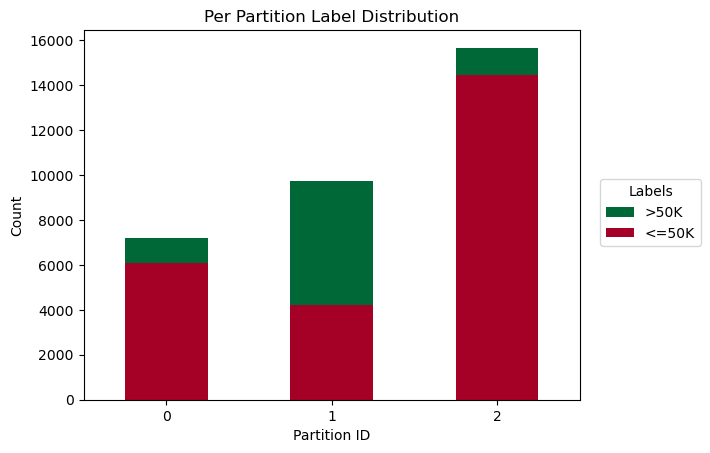

In [32]:
# print("Data distribution for IID partitions:")
# showDataDist(iid_partitions, "income")

print("Data distribution for non-IID partitions:")
showDataDist(non_iid_partitions, "income")

In [39]:
        
def preprocess_data(pdf):

    pdf.replace("?", np.nan, inplace=True)
    pdf = pdf.dropna()
    
    new_col_name = []

    for col in pdf.columns:
        new_col_name.append(col.replace(".", "_"))
        
    pdf = pdf.rename(columns=dict(zip(pdf.columns, new_col_name)))
        
    columns_to_encode = ["workclass", "occupation", "native_country", "income"]

    encoder = OneHotEncoder(drop = 'first', handle_unknown="error", dtype=np.int8)
    encoded_data = encoder.fit_transform(pdf[columns_to_encode]).toarray()

    encoded_df = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out(), index=pdf.index)
    
    pdf_final = pd.concat([pdf, encoded_df], axis=1)

    pdf_final = pdf_final.drop(columns=["workclass", "occupation", "native_country", "income", "race", "relationship", "marital_status", "fnlwgt", "education", "sex"])
    
    return pdf_final

In [40]:
pdf = preprocess_data(non_iid_partitions.load_partition(0).to_pandas())

In [41]:
pdf.shape

(6644, 65)

In [47]:
client_partitions = []

for i in range(3):
    part = preprocess_data(non_iid_partitions.load_partition(i).to_pandas())
    client_partitions.append(part)
    print(f"Partition {i} shape: {part.shape}")

Partition 0 shape: (6644, 65)
Partition 1 shape: (9157, 64)
Partition 2 shape: (14361, 64)


In [48]:
client_partitions[0]

,age,education_num,capital_gain,capital_loss,hours_per_week,workclass_Local-gov,workclass_Private,workclass_Self-emp-inc,workclass_Self-emp-not-inc,workclass_State-gov,...,native_country_Puerto-Rico,native_country_Scotland,native_country_South,native_country_Taiwan,native_country_Thailand,native_country_Trinadad&Tobago,native_country_United-States,native_country_Vietnam,native_country_Yugoslavia,income_>50K
0,19,10,0,0,16,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,22,10,0,0,40,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,40,9,0,0,40,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,33,9,0,0,40,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,44,13,0,0,60,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7179,52,9,0,0,40,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,1
7180,53,14,7298,0,60,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,1
7181,27,13,0,0,20,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
7182,21,12,0,0,40,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [50]:
client_data = {}

for idx, pdf in enumerate(client_partitions):
    X = pdf.drop('income_>50K', axis=1).values
    y = pdf['income_>50K'].values
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    client_data[idx] = {
        'X_train': X_train,
        'y_train': y_train,
        'X_test': X_test,
        'y_test': y_test
    }

In [53]:
client_data

{0: {'X_train': array([[ 36,  10,   0, ...,   1,   0,   0],
         [ 44,  14,   0, ...,   0,   0,   0],
         [ 51,  12,   0, ...,   1,   0,   0],
         ...,
         [ 38,   9,   0, ...,   1,   0,   0],
         [ 44,   7,   0, ...,   1,   0,   0],
         [ 77,   9, 401, ...,   1,   0,   0]], dtype=int64),
  'y_train': array([0, 0, 0, ..., 0, 0, 0], dtype=int8),
  'X_test': array([[31, 13,  0, ...,  1,  0,  0],
         [18, 10,  0, ...,  1,  0,  0],
         [19, 10,  0, ...,  1,  0,  0],
         ...,
         [21, 12,  0, ...,  1,  0,  0],
         [21, 10,  0, ...,  1,  0,  0],
         [18, 10,  0, ...,  1,  0,  0]], dtype=int64),
  'y_test': array([0, 0, 0, ..., 0, 0, 0], dtype=int8)},
 1: {'X_train': array([[  74,   10,    0, ...,    1,    0,    0],
         [  44,   10,    0, ...,    1,    0,    0],
         [  46,    9,    0, ...,    1,    0,    0],
         ...,
         [  30,   13, 7688, ...,    1,    0,    0],
         [  47,   13,    0, ...,    1,    0,    0],


In [56]:
class FederatedClient(fl.client.NumPyClient):
    def __init__(self, model, X_train, y_train, X_test, y_test):
        self.model = model
        self.X_train, self.y_train = X_train, y_train
        self.X_test, self.y_test = X_test, y_test

    def get_parameters(self):
        return [self.model.coef_.copy(), self.model.intercept_.copy()]
    
    def set_parameters(self, parameters):
        self.model.coef_, self.model.intercept_ = parameters

    def fit(self, parameters, config):
        self.set_parameters(parameters)
        self.model.fit(self.X_train, self.y_train)
        return self.get_parameters(), len(self.X_train), {}

    def evaluate(self, parameters, config):
        self.set_parameters(parameters)
        preds = self.model.predict(self.X_test)
        loss = log_loss(self.y_test, self.model.predict_proba(self.X_test))
        acc = accuracy_score(self.y_test, preds)
        return loss, len(self.X_test), {"accuracy": acc}